In [1]:
import gym
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

<img src="./asd.png" style="width: 70%"> </img>

In [58]:
#%%
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        self.dones = []

    def forward(self, x, only_value=False):
        if only_value:
            with torch.no_grad():
                x = F.relu(self.affine1(x))
                state_values = self.value_head(x)
                return state_values

        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, gamma, start_value, dones):
#     print(len(dones))
#     print(len(rewards_arr))
    assert len(dones) == len(rewards_arr), "qqq"
    R = start_value
    returns = []
    for i in reversed(range(len(rewards_arr))):
        r = rewards_arr[i]
        done = dones[i]
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean())/(returns.std() + 1e-5)
    return returns

def discount_rewards_2(rewards_arr, gamma):
#     print(len(dones))
#     print(len(rewards_arr))

    for i in reversed(range(len(rewards_arr))):
        r = rewards_arr[i]
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean())/(returns.std() + 1e-5)
    return returns

def train_on_rollout(gamma=0.99):
    returns = discount_rewards_2(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def train_on_batch(observation, done, gamma, T):
    returns = None
    if done:
        returns = discount_rewards(policy.rewards, gamma, 0, policy.dones)
    else:
        next_state = torch.from_numpy(observation).float()
        final_value = policy(next_state, only_value=True)
        returns = discount_rewards(policy.rewards, gamma, final_value.item(), policy.dones)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.mse_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss_actor = torch.stack(actor_loss).mean()
#     writer.add_scalar("actor loss", loss_actor, T)
    loss_critic = torch.stack(critic_loss).mean()
#     writer.add_scalar("critic loss", loss_actor, T)
    loss = loss_actor + loss_critic
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def learn_episodic_A2C(N_eps, max_ep_steps):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    batch_update = 50
    env._max_episode_steps = max_ep_steps
    T = 1
    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.dones.append(done)
            policy.rewards.append(reward)
            total_r += reward
            if T % batch_update == 0:
                train_on_batch(observation, done, df, T)
            T += 1
            if done:
#                 train_on_rollout(0.99)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
#         writer.add_scalar("Ep reward", total_r, i_episode)

    # writer.export_scalars_to_json("./all_scalars.json")
#     writer.close()
    env.close()
    return rewards
# N_EPS = 2000
# rewards_A2C = learn_episodic_A2C(N_EPS, 500)

if __name__ == '__main__':
#     writer = SummaryWriter()
    rewards = learn_episodic_A2C(5000, 500)
    print(rewards)
    plt.plot(np.arange(len(rewards)), rewards)

Episode 99 finished after 181 timesteps
Episode 199 finished after 36 timesteps
Episode 299 finished after 133 timesteps
Episode 399 finished after 109 timesteps
Episode 499 finished after 227 timesteps
Episode 599 finished after 500 timesteps
Episode 699 finished after 211 timesteps
Episode 799 finished after 289 timesteps
Episode 899 finished after 127 timesteps
Episode 999 finished after 149 timesteps
Episode 1099 finished after 40 timesteps
Episode 1199 finished after 102 timesteps
Episode 1299 finished after 159 timesteps
Episode 1399 finished after 500 timesteps
Episode 1499 finished after 462 timesteps


KeyboardInterrupt: 

Episode 99 finished after 120 timesteps
Episode 199 finished after 186 timesteps
Episode 299 finished after 210 timesteps
Episode 399 finished after 101 timesteps
Episode 499 finished after 112 timesteps


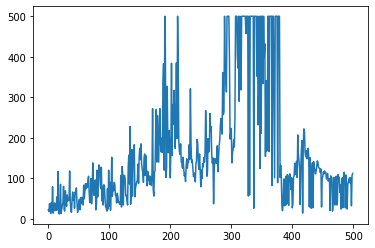

In [40]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        self.dones = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def train_on_rollout(gamma=0.99):
    returns = discount_rewards(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    
def train_on_batch(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.mean().backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def learn_episodic_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 30

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                train_on_batch(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards
rewards_A2C = learn_episodic_A2C(N_EPS, 500)
plt.plot(rewards_A2C)

PPO:

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.actions = []
        self.rewards = []
        self.dones = []
        self.states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

policy = Policy()
policy_old = Policy()
policy_old.load_state_dict(policy.state_dict())

optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy_old(state)
    m = Categorical(probs)
    action = m.sample()
    policy.actions.append(action.item())
    policy.log_probs.append(m.log_prob(action).item())
    policy.states.append(state)
#     policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

# def train_on_rollout(gamma=0.99):
#     returns = discount_rewards(policy.rewards, gamma)
#     actor_loss = []
#     critic_loss = []
#     for (log_prob, value), r in zip(policy.saved_actions, returns):
#         advantage = r - value.item()
#         actor_loss.append(-log_prob * advantage)
#         critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
#     optimizer.zero_grad()
#     loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
#     loss.backward()
#     optimizer.step()
#     del policy.rewards[:]
#     del policy.saved_actions[:]
    
# def train_on_batch(gamma=0.99, final_obs=None, done=True):
#     state = torch.from_numpy(final_obs).float()
#     _, state_value = policy(state)
#     final_value = state_value.detach() if not done else 0.0
    
#     returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
#     actor_loss = []
#     critic_loss = []
#     for (log_prob, value), r in zip(policy.saved_actions, returns):
#         advantage = r - value.item()
#         actor_loss.append(-log_prob * advantage)
#         critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
#     optimizer.zero_grad()
#     loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
#     loss.mean().backward()
#     optimizer.step()
#     del policy.rewards[:]
#     del policy.saved_actions[:]
#     del policy.dones[:]
def evaluate_policy():
    
    # returns state_values, 

def train_ppo(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    
    
    # PPO OLD VALUES
    for i in range(4):
        
        # compute loss for clip params
        
        # compute loss for value function
        
        # compute entropy bonus
        
    

def learn_episodic_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 30

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                train_ppo(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards
rewards_A2C = learn_episodic_A2C(N_EPS, 500)
plt.plot(rewards_A2C)

### TODO

try to train the model on r + V(x') - V(x) advantage